In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 840.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not curre

In [ ]:
!pip install transformers pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00


## Importing Required Libraries

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use('ggplot')

## Dataset

In [ ]:
# Read in data
df = pd.read_csv("delhi.csv")
print(df.shape)

(4917, 2)


In [ ]:
df.describe()

,hotel name,reviews
count,4917,4917
unique,130,4887
top,the imperial,??????????
freq,250,5


In [ ]:
df.head(5)

,hotel name,reviews
0,airport hotel,Not as bad as I expected If you compare this h...
1,airport hotel,Don't stay !! Wrote a mail and got reservation...
2,airport hotel,Better stay at Airport Due to unavailability i...
3,airport hotel,My worst hotel experience ever! I had to stay ...
4,airport hotel,very poor do not stay here we decided to stay ...


## Bert Model

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bert_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
# calculate sentiment scores
def sentiment_score_bert(review):
    tokens = bert_tokenizer.encode(review, return_tensors='pt')
    result = bert_model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
tqdm.pandas(desc='bert model')  
df['bert_rating']=df['reviews'].progress_apply(lambda x: sentiment_score_bert(x[:512]))  

bert model:   0%|          | 0/4917 [00:00<?, ?it/s]

,hotel name,reviews,bert_rating
0,airport hotel,Not as bad as I expected If you compare this h...,3
1,airport hotel,Don't stay !! Wrote a mail and got reservation...,1
2,airport hotel,Better stay at Airport Due to unavailability i...,2
3,airport hotel,My worst hotel experience ever! I had to stay ...,1
4,airport hotel,very poor do not stay here we decided to stay ...,1
5,airport hotel,Not Recommended Because of a unexpected layove...,2
6,airport hotel,Stay Away!!!!!! Had to transit via Delhi on my...,1
7,airport hotel,"Worst hotel ever been High rates, bad rooms, c...",1
8,airport hotel,Bruyant,2
9,ajanta hotel,a decent hotel in an interesting part of Delhi...,4


In [ ]:
hotel_ratings = df.groupby(['hotel name'], as_index=False)['bert_rating'].mean()
hotel_ratings

,hotel name,bert_rating
0,airport hotel,1.555556
1,ajanta hotel,3.170330
2,ajay guest house,1.916667
3,aman new delhi,4.750000
4,amarya garden,4.850000
...,...,...
125,uppal s orchid an ecotel hotel,3.542857
126,velvet apple,4.000000
127,vivek hotel,2.758621
128,york hotel,2.300000


In [ ]:
hotel_ratings = pd.DataFrame(hotel_ratings)
hotel_ratings.shape

(130, 2)

### Highest Rated Hotel

In [ ]:
mx = hotel_ratings['bert_rating'].max()
print(mx) 
res = []
for index, row in hotel_ratings.iterrows():
    if row['bert_rating'] == mx:
      res.append([row['hotel name'], row['bert_rating']])

res

4.85


[['amarya garden ', 4.85]]

### Lowest rated Hotel

In [ ]:
mn = hotel_ratings['bert_rating'].min()
print(mn) 
res = [['hotel_name', 'rating']]
for index, row in hotel_ratings.iterrows():
    if row['bert_rating'] == mn:
      res.append([row['hotel name'], row['bert_rating']])

lowest_rated = pd.DataFrame(res)
lowest_rated

1.5


,0,1
0,hotel_name,rating
1,petite hotels,1.5


In [ ]:
hotel_ratings['rating_categories'] = pd.cut(hotel_ratings['bert_rating'], bins=3, labels=('bad', 'average', 'good'))
hotel_ratings

,hotel name,bert_rating,rating_categories
0,airport hotel,1.555556,bad
1,ajanta hotel,3.170330,average
2,ajay guest house,1.916667,bad
3,aman new delhi,4.750000,good
4,amarya garden,4.850000,good
...,...,...,...
125,uppal s orchid an ecotel hotel,3.542857,average
126,velvet apple,4.000000,good
127,vivek hotel,2.758621,average
128,york hotel,2.300000,bad


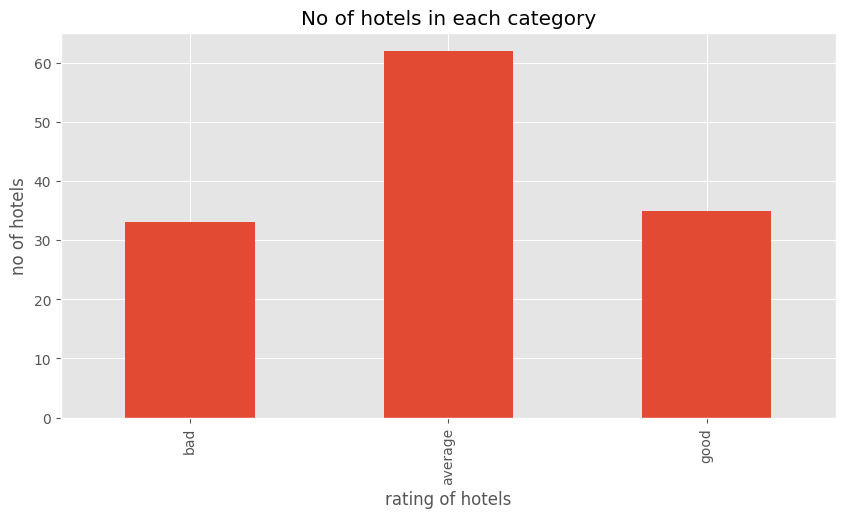

In [ ]:
ax = hotel_ratings['rating_categories'].value_counts().sort_index() \
    .plot(kind='bar',
          title='No of hotels in each category',
          figsize=(10, 5))
ax.set_xlabel('rating of hotels')
ax.set_ylabel('no of hotels')
plt.show()

##  BERTWEET MODEL

In [ ]:
bwt_data = df

In [ ]:
bwt_tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')
bwt_model = AutoModelForSequenceClassification.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
example = bwt_data['reviews'][0]
example

"Not as bad as I expected If you compare this hotel to American standards, then yes I guess I would say this isn't the best place to stay for the money. But in comparison to India standards it wasn't all that bad. Maybe I just lucked out. The location was perfect in relation to the airport (domestic and international terminals). My bathroom was clean so was my bedding, the staff was responsive. I did order room service which wasn't to good, the menu was strictly vegetarian and over priced. I got much better quality and tasting food from the Shangra Lai hotel in Delhi for a little bit more money. Would I stay here again for a night...yes. I probably wouldn't for more than one night though. "

In [ ]:
tokens = bwt_tokenizer.encode(example[:158], return_tensors='pt')
result = bwt_model(tokens)

In [ ]:
result.logits

tensor([[ 2.0834, -0.2541, -2.1358]], grad_fn=<AddmmBackward>)

In [ ]:
res = torch.argmax(result.logits)+1
res

tensor(1)

In [ ]:
tokens = bert_tokenizer.encode(example[:512], return_tensors='pt')
result = bert_model(tokens)
res = torch.argmax(result.logits)+1
res

tensor(3)